In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook

In [40]:
import warnings
from sklearn.exceptions import DataConversionWarning
# import warnings filter
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [14]:
raw_data = pd.read_csv("corn_data.csv")
raw_data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1126,1127,1128,1129,1130,1131,1132,1133,1134,output
0,0,1,-1,1,1,1,0,1,-1,1,...,-1,1,-1,1,1,-1,0,0,-1,2.516485
1,1,1,-1,1,1,-1,-1,1,-1,1,...,-1,1,-1,0,1,-1,-1,1,0,1.640909
2,2,0,1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,1,1,-1,-1,1,0,0.416348
3,3,1,1,1,0,-1,1,1,-1,1,...,-1,1,-1,-1,1,-1,-1,1,0,1.338558
4,4,1,1,1,0,-1,-1,1,0,1,...,-1,1,-1,0,-1,-1,1,1,0,1.729517


In [15]:
X = raw_data.iloc[:,1:-1]
y = raw_data.iloc[:,-1:]
total_count = len(y)
print("min:",min(np.array(y))[0],"max:",max(np.array(y))[0],"Total:",total_count)


min: 0.0117532464005208 max: 4.9270454514617015 Total: 264


### Visualize Our Data

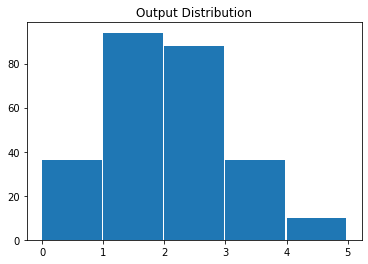

In [16]:
hist, bin_edges = np.histogram(y, bins=5, range=(0,5))
fig = plt.figure()
plt.bar( bin_edges[:-1],hist, width=.98,align="edge")
plt.title("Output Distribution")
plt.show()


### Stratify the Data
Added on May 27, 2020
    
    
    

#### Take this simple step to stratify our data...

In [42]:
y_stf = np.array(y,dtype="int")
y_stf[:15].T #print out the first 15 elements for visualization purposes

array([[2, 1, 0, 1, 1, 2, 1, 1, 2, 2, 2, 2, 3, 3, 2]])

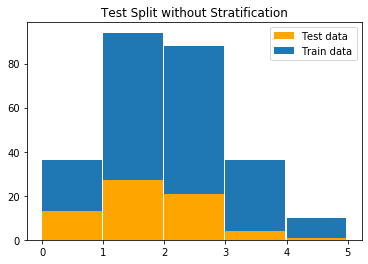

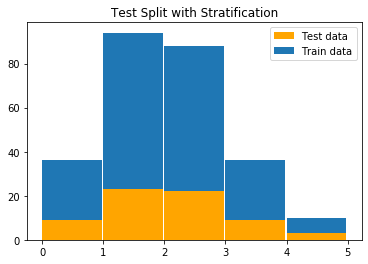

<Figure size 1440x720 with 0 Axes>

In [138]:
from sklearn.model_selection import train_test_split  

split = 0.25
#Without Stratification
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=split,random_state=1)
hist_tr, bin_edges_tr = np.histogram(y_train, bins=5, range=(0,5))
hist_test, bin_edges_test = np.histogram(y_test, bins=5, range=(0,5))
fig,ax = plt.subplots()
ax.bar( bin_edges_test[:-1],hist_test, width=.98,align="edge",color="orange",label="Test data")
ax.bar( bin_edges_tr[:-1],hist_tr, width=.98,align="edge",bottom=hist_test,label="Train data")
ax.set_title("Test Split without Stratification")
ax.legend()


#With Stratification
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=split,random_state=1,stratify = y_stf)
hist_tr, bin_edges_tr = np.histogram(y_train, bins=5, range=(0,5))
hist_test, bin_edges_test = np.histogram(y_test, bins=5, range=(0,5))
fig,ax = plt.subplots()
ax.bar( bin_edges_test[:-1],hist_test, width=.98,align="edge",color="orange",label="Test data")
ax.bar( bin_edges_tr[:-1],hist_tr, width=.98,align="edge",bottom=hist_test,label="Train data")
ax.set_title("Test Split with Stratification")
ax.legend()
plt.show()

In [231]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
# we use r2 because we are doing regression, not classification

class Scorer:
    def __init__(self,X,y):
        self.scores = {}
        self.X = X
        self.y = y
        self.split = 0.25
        self.stratify = np.array(y,dtype="int")
        self.iterations = 20
        
    def test(self,name,clf):
        scores = []
        for i in range(self.iterations):
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=self.split,
                                                                random_state=i,stratify=self.stratify)
            clf.fit(X_train,y_train)
            y_predict_tr = clf.predict(X_train)
            y_predict = clf.predict(X_test)    
            scores.append([r2_score(y_train,y_predict_tr),r2_score(y_test,y_predict)])  
        scores = np.array(scores)
        self.scores[name] = [np.mean(scores[:,0]),np.mean(scores[:,1])]
    
    def labels(self):
        return [x for x in self.scores]
                        
    def train_scores(self):
        sc = np.array([self.scores[x] for x in self.scores])
        return sc[:,0]
        
    def test_scores(self):
        sc = np.array([self.scores[x] for x in self.scores])
        return sc[:,1]
    

    def find_best_params(self,clf,grid):
        gd_sr = GridSearchCV(estimator=clf,
                               param_grid=grid,
                               scoring='r2', # note the use of scoring here.
                               cv=5, iid=False)
        gd_sr.fit(X_train_FS, y_train_FS)
        return gd_sr.best_params_

    def draw_hscores(self):
        plt.rcdefaults()
        fig, ax = plt.subplots()

        # Example data
        labels = self.labels()
        y_pos = np.arange(len(labels))
        performance = self.train_scores()
        width = 0.4  # the width of the bars
        # ax.barh(y_pos, performance, align='center')
        rects1 = ax.barh(y_pos - width/2, self.train_scores(), width, label='Train Score')
        rects2 = ax.barh(y_pos + width/2, self.test_scores(), width, label='Test Score')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(labels)
        ax.invert_yaxis()  # labels read top-to-bottom
        def autolabel(rects):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for rect in rects:
                width = rect.get_width()
                i = 0
                if width < 0:
                    i = abs(width)+45
                elif width < 0.1:
                    i = 30
                ax.annotate('{:.3f}'.format(width),
                            xy=(width, rect.get_y() + rect.get_height() / 2),
                            xytext=(i,0),  # 3 points vertical offset
                            textcoords="offset points",
                            va='center', ha='right')
        autolabel(rects1)
        autolabel(rects2)
        fig = plt.gcf()
        fig.set_size_inches(8,8) 
        ax.set_xlabel('Performance')
        ax.set_title('R2 Scores by Predictors')
        
    def draw_scores(self):
        if (len(self.labels())>=6):
            self.draw_hscores()
        else:
            x = np.arange(len(self.labels()))  # the label locations
    #         y = np.linspace(0,1,11,endpoint=True)
            width = 0.35  # the width of the bars
            fig, ax = plt.subplots()
            rects1 = ax.bar(x - width/2, self.train_scores(), width, label='Train Score')
            rects2 = ax.bar(x + width/2, self.test_scores(), width, label='Test Score')
            # Add some text for labels, title and custom x-axis tick labels, etc.
            ax.set_ylabel('R2 Scores')
            ax.set_title('R2 Scores by Predictors')
            ax.set_xticks(x)
    #         ax.set_yticks(y)
            ax.set_xticklabels(self.labels())
            ax.legend()

            def autolabel(rects):
                """Attach a text label above each bar in *rects*, displaying its height."""
                for rect in rects:
                    height = rect.get_height()
                    i = 0
                    if height < 0:
                        i = abs(height)+10
                    ax.annotate('{:.3f}'.format(height),
                                xy=(rect.get_x() + rect.get_width() / 2, height),
                                xytext=(0, 1+i),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom')

            autolabel(rects1)
            autolabel(rects2)
            fig = plt.gcf()
            fig.set_size_inches(9,7)        
            plt.show()
               
    def plot_graph(y,y_pred,title):
        fig, ax = plt.subplots()
        plt.axis([0,5,0,5])
        ax.set_title(title)
        plt.plot(y,y_pred,'o',color="black")
        plt.plot([x for x in np.arange(0,6)],[x for x in np.arange(0,6)],'r--',)
        plt.show()
    
    def clear_scores(self):
        self.scores = {}

In [232]:
scorer = Scorer(X,y)

<IPython.core.display.Javascript object>


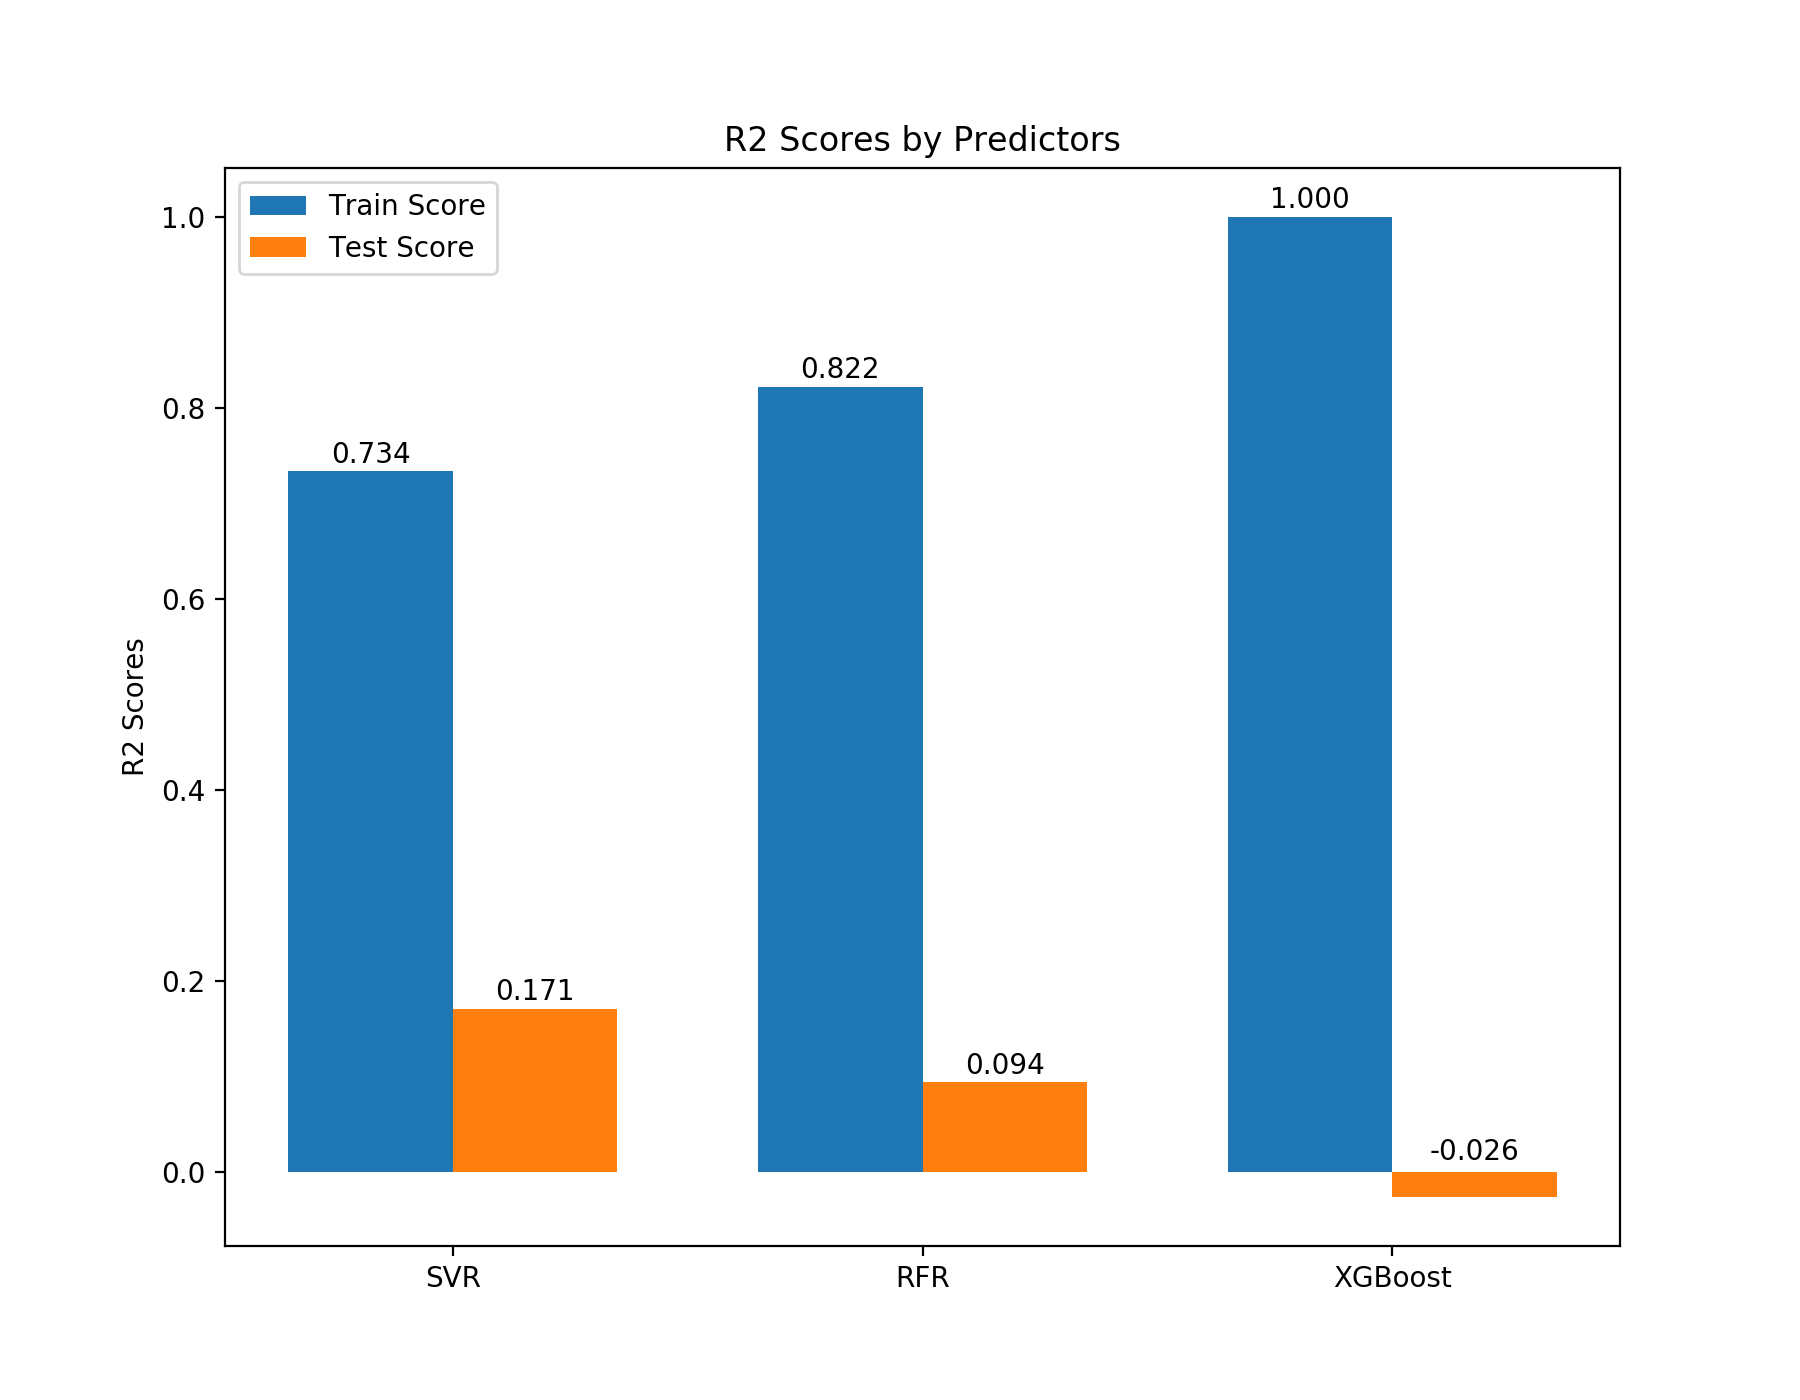

In [233]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


xgb = XGBRegressor()
svr = SVR()
rfr = RandomForestRegressor()
scorer.test("SVR",svr)
scorer.test("RFR",rfr)
scorer.test("XGBoost",xgb)

scorer.scores
scorer.draw_scores()

### Some intriguing observations:
1.SVR and XGBoost produce the same result when repeated using the same initial condition. RFR produces different result each time


<IPython.core.display.Javascript object>


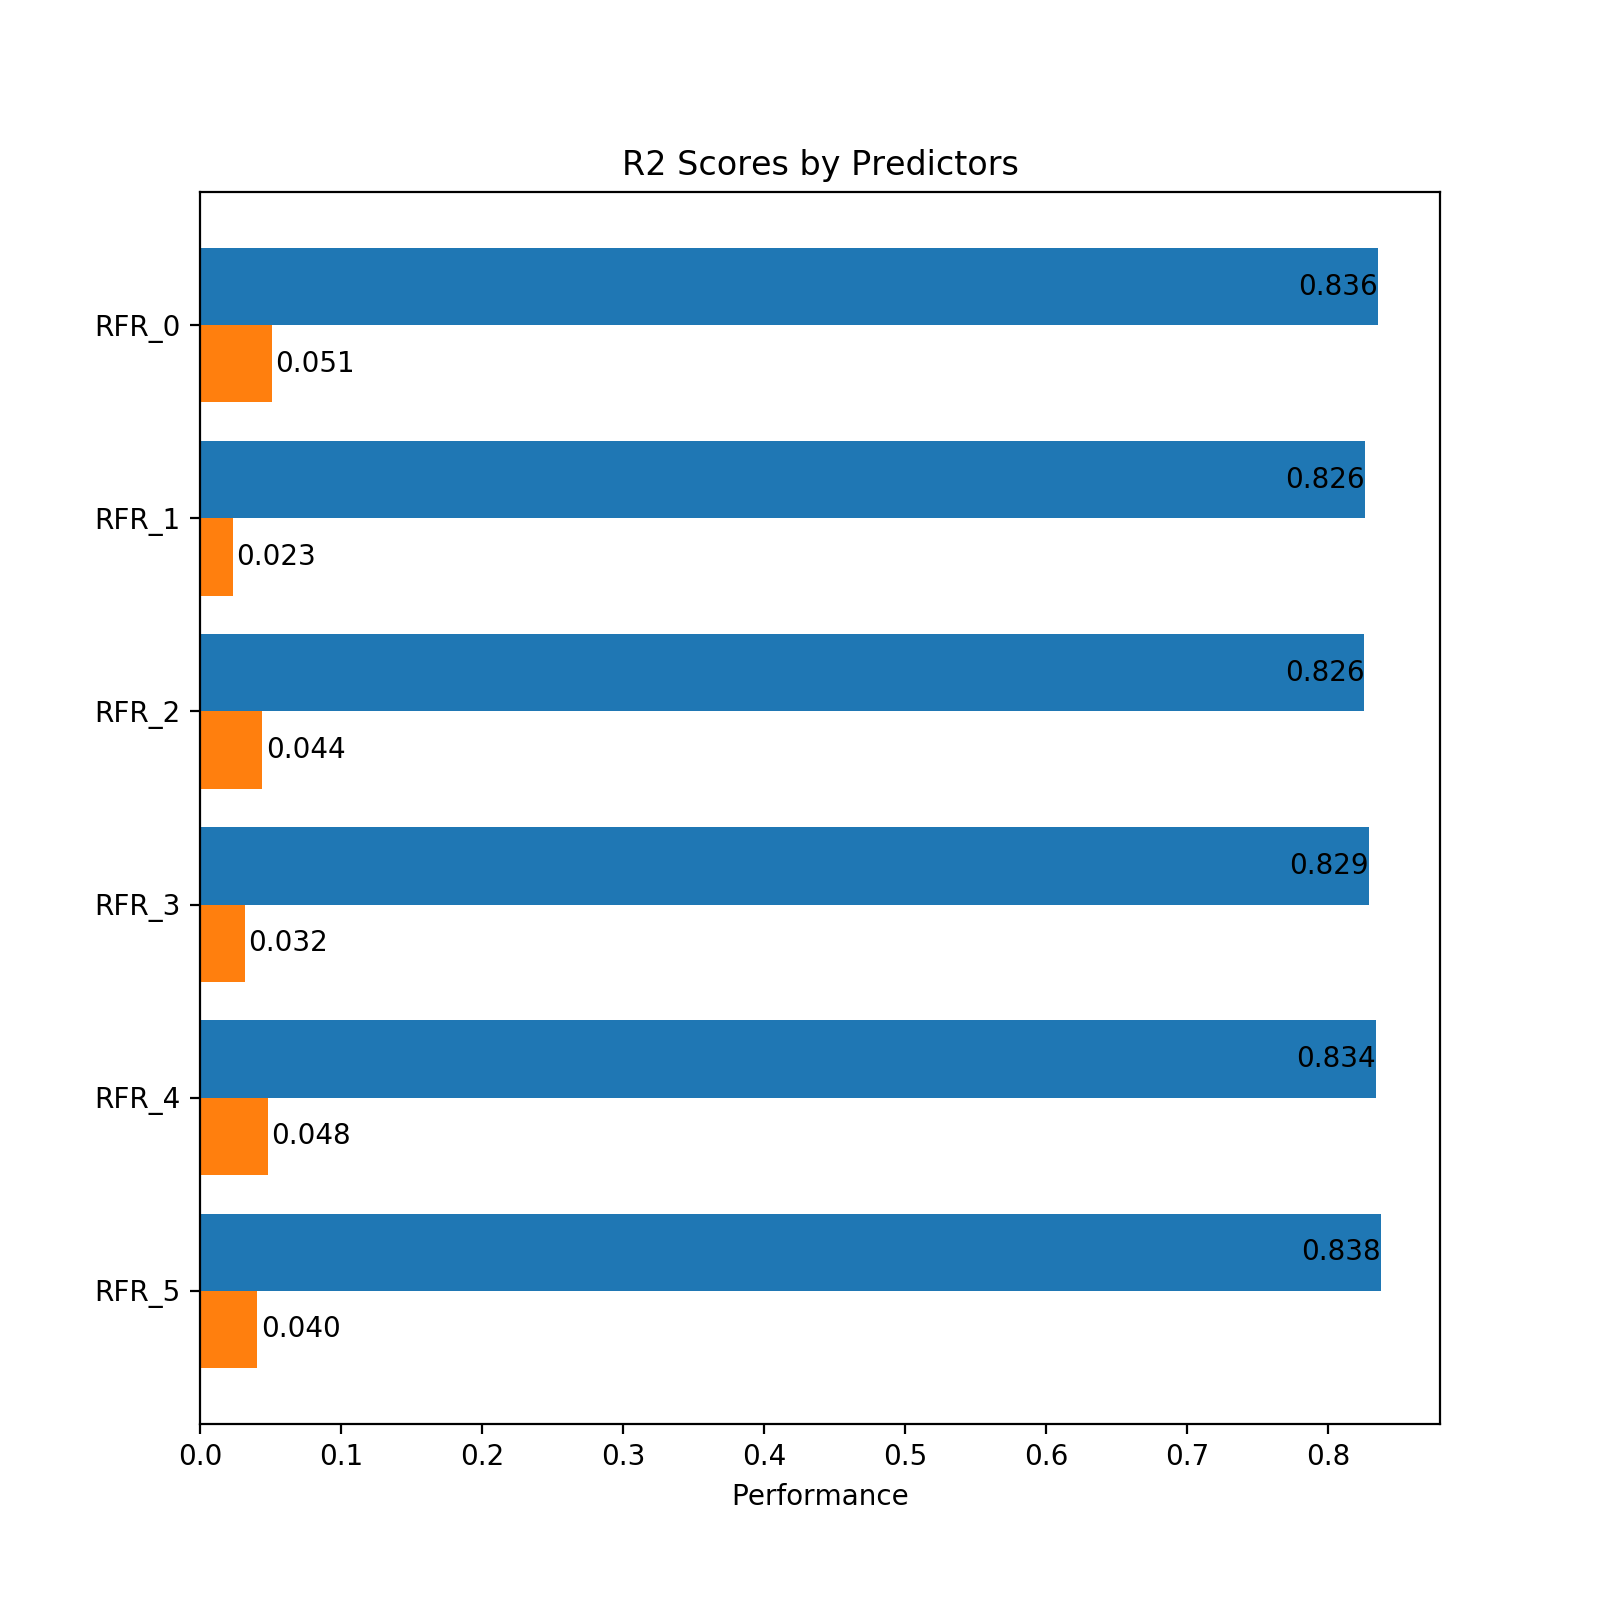

In [234]:
scorer.clear_scores()
for i in range(6):
    scorer.test("RFR_"+str(i),rfr)
scorer.draw_scores()

<IPython.core.display.Javascript object>


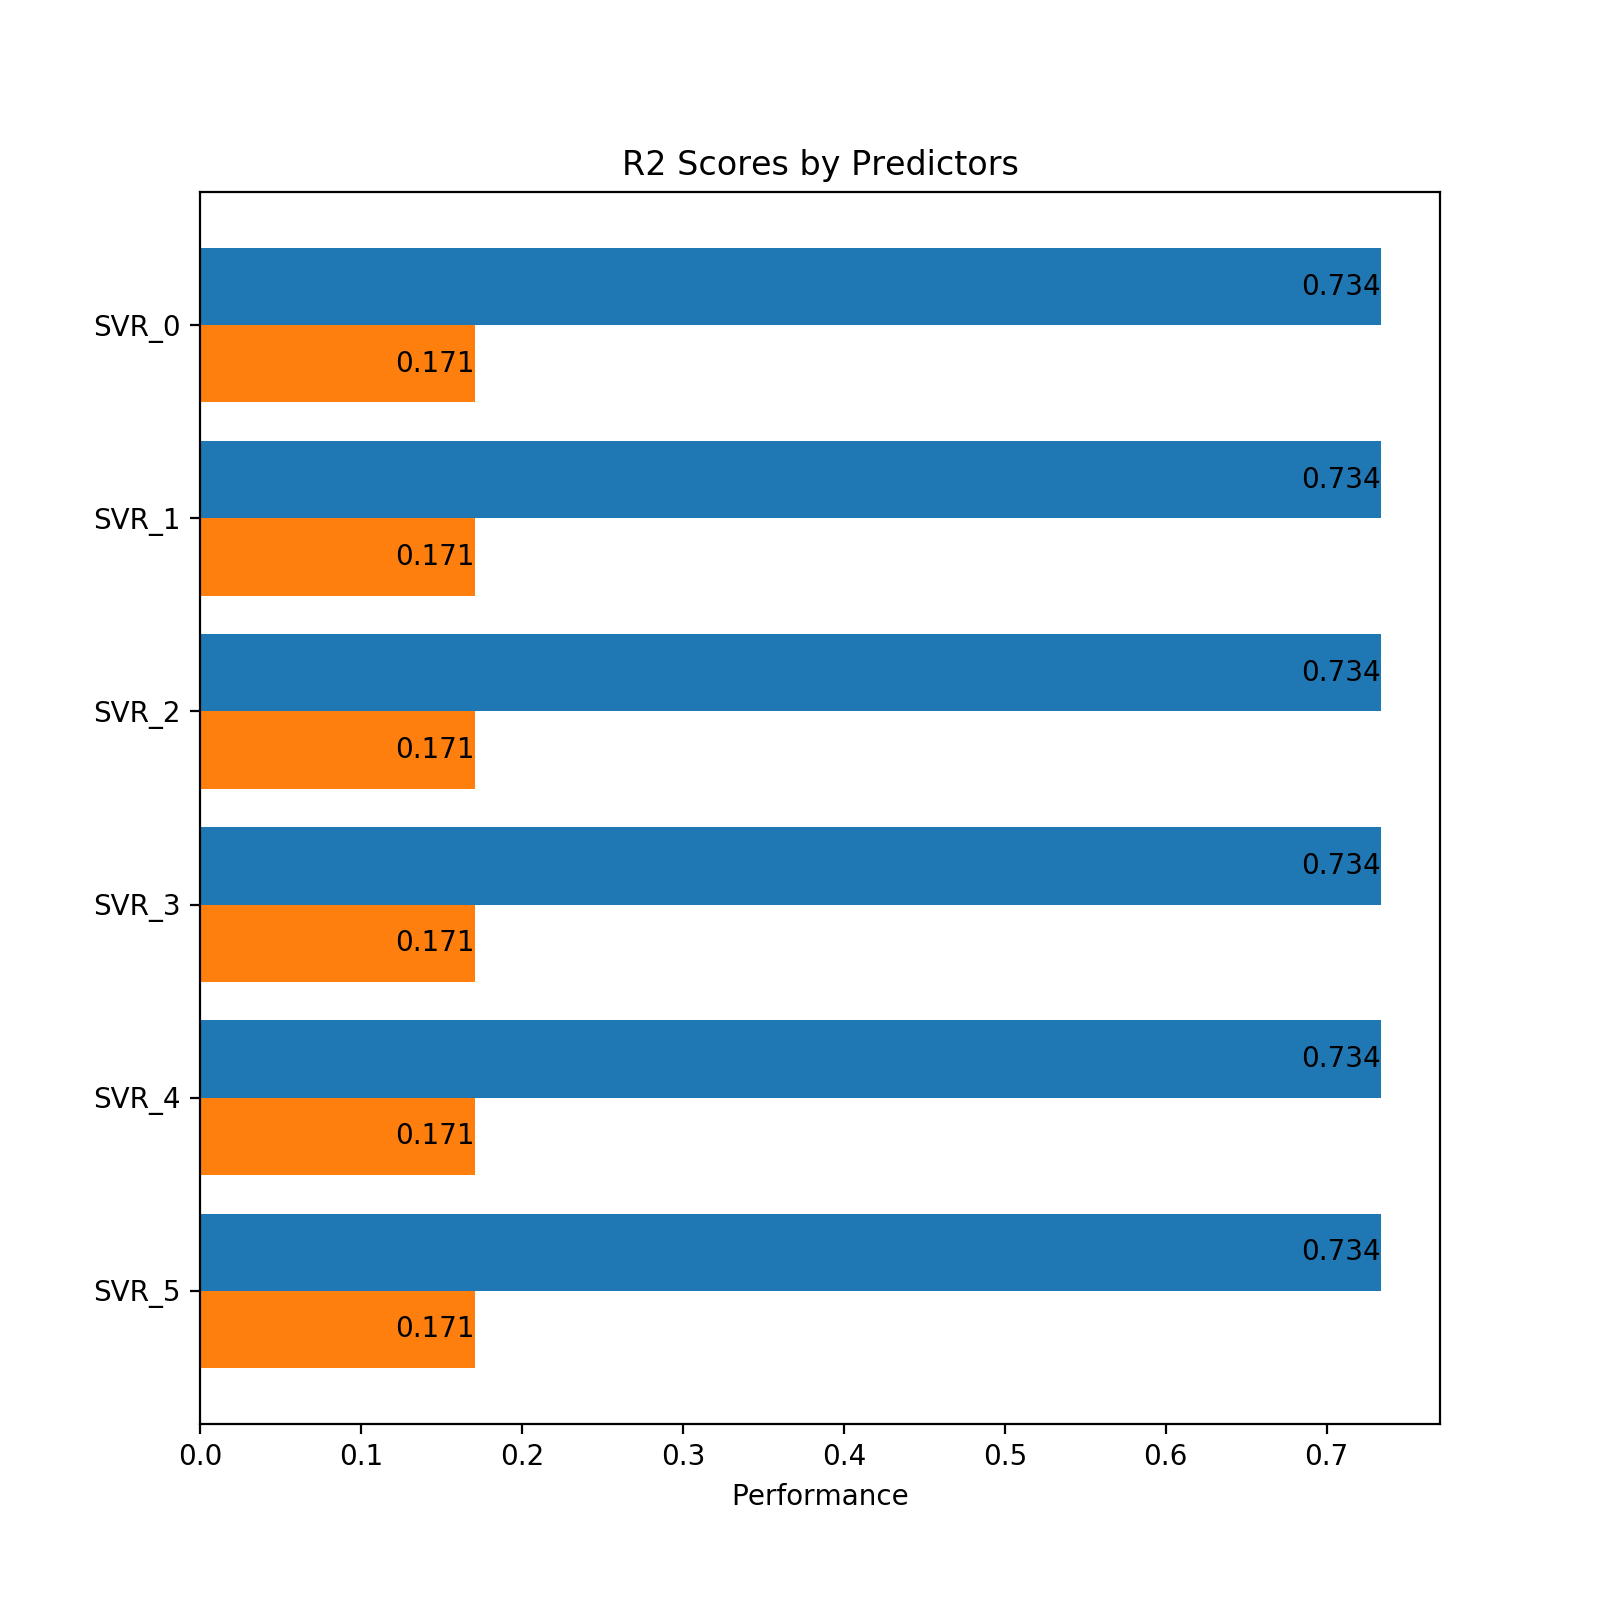

In [235]:
scorer.clear_scores()
for i in range(6):
    scorer.test("SVR_"+str(i),svr)
scorer.draw_scores()

<IPython.core.display.Javascript object>


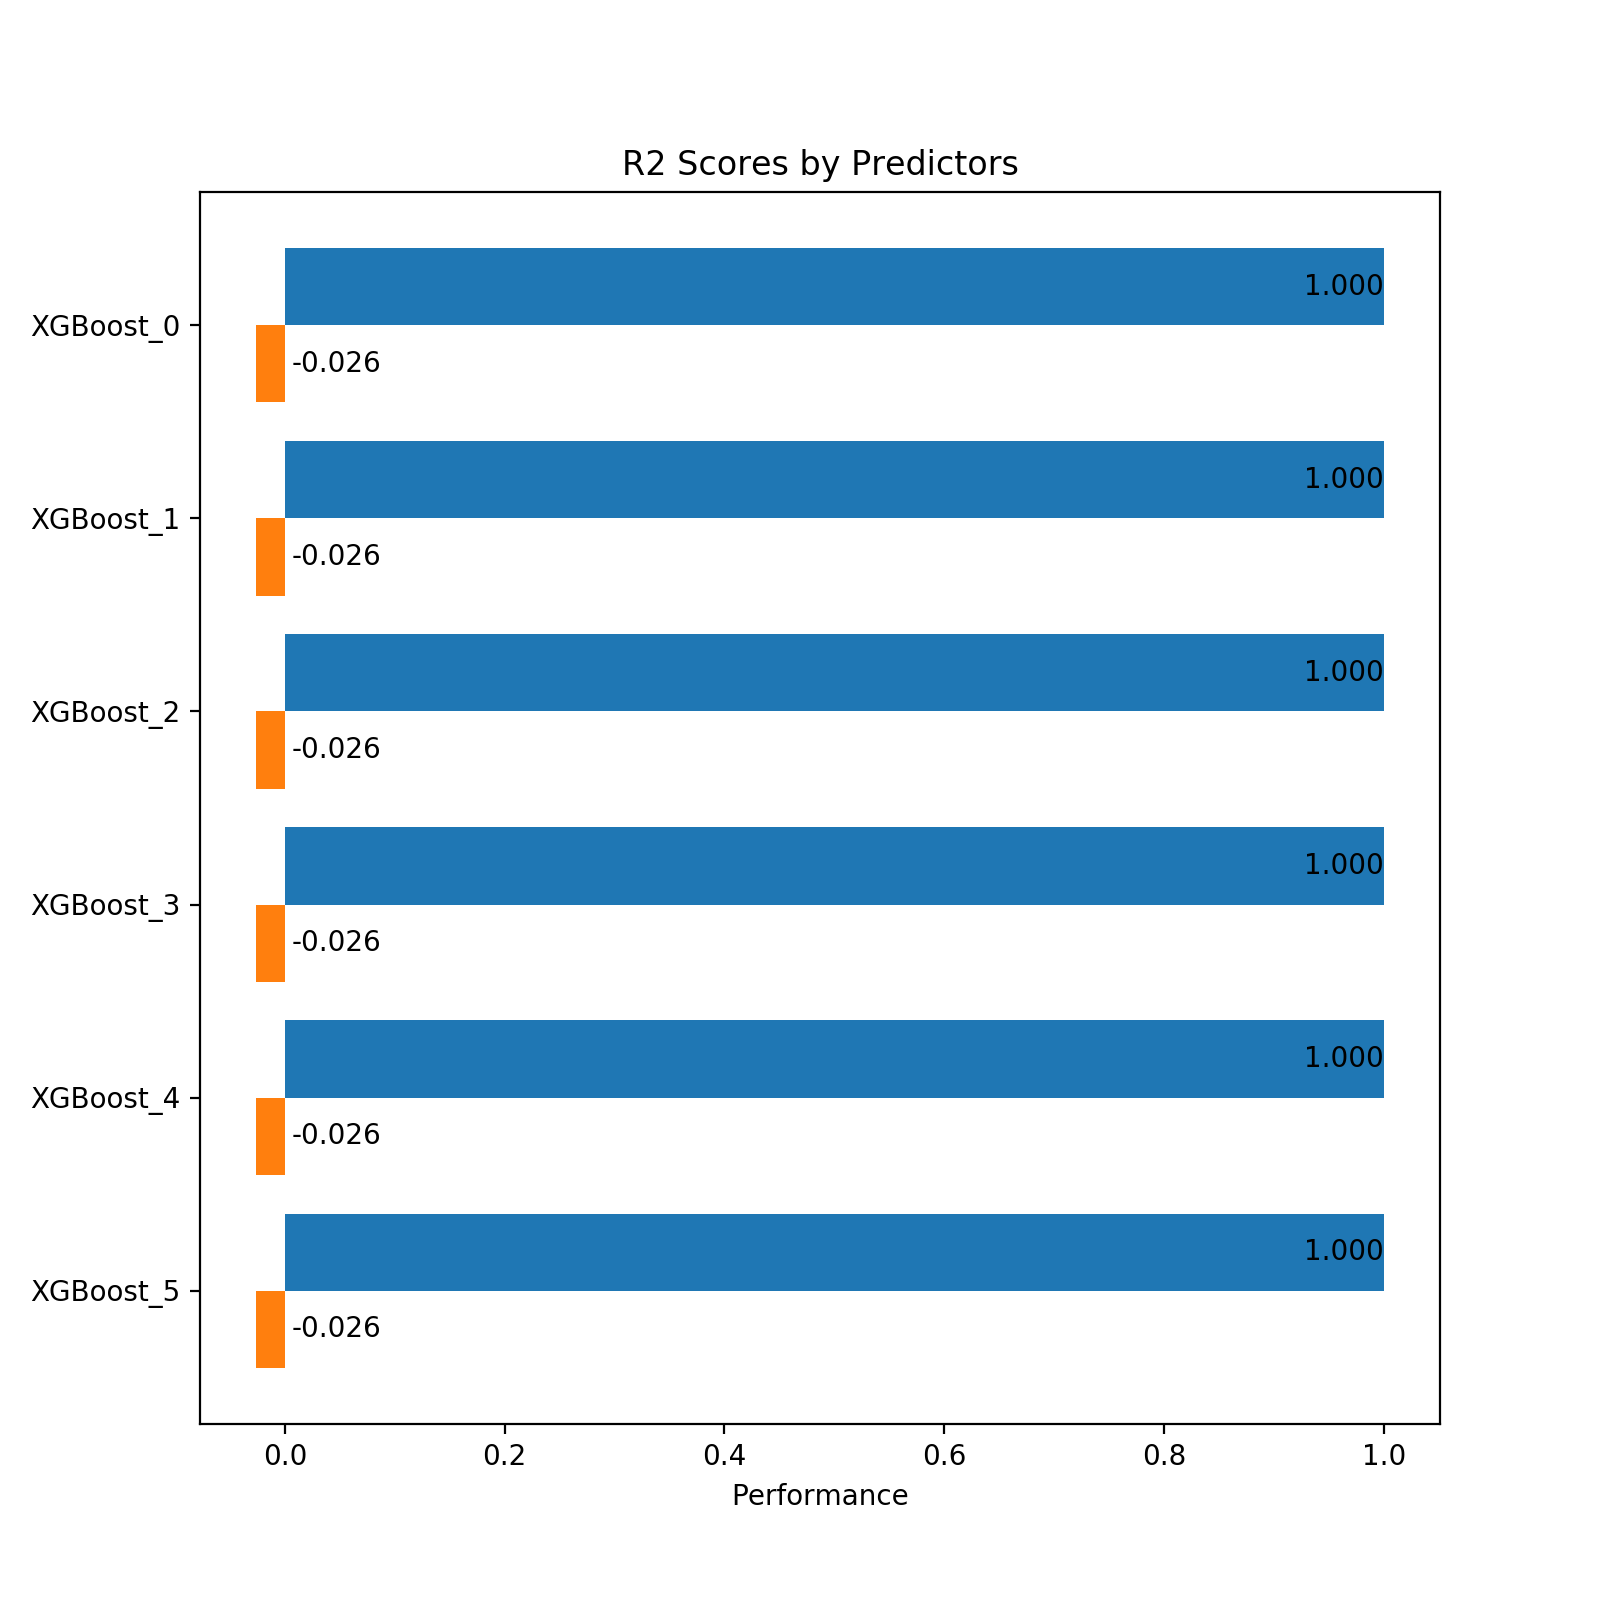

In [236]:
scorer.clear_scores()
for i in range(6):
    scorer.test("XGBoost_"+str(i),xgb)
scorer.draw_scores()

### Use Grid Search to Improve our performance

In [196]:
grid = grid = {
    'C' : [10**i for i in range(-10,10,1)] 
   }

 

### Use SelectKBest 

In [192]:
from sklearn.feature_selection import SelectKBest,f_regression

skb = SelectKBest(f_regression,k=750)

X_train_FS = skb.fit_transform(X_train, y_train)
X_test_FS = skb.transform(X_test)

print(X_train.shape,X_test.shape)
print(X_train_FS.shape,X_test_FS.shape)

(198, 1135) (66, 1135)
(198, 750) (66, 750)


C:\Program Files\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [194]:
# from sklearn import svm

# reg_svr = svm.SVR()
# reg_svr.fit(X_train,y_train)
# y_predict_tr = reg_svr.predict(X_train)
# y_predict = reg_svr.predict(X_test)
# plot_graph(y_train,y_predict_tr,"Training Set")
# plot_graph(y_test,y_predict,"Test Set")

# reg_svr

In [193]:
# from sklearn.linear_model import LinearRegression

# reg_ln = LinearRegression()
# reg_ln.fit(X_train,y_train)
# y_predict_tr = reg_ln.predict(X_train)
# y_predict = reg_ln.predict(X_test)
# plot_graph(y_train,y_predict_tr,"Training Set")
# plot_graph(y_test,y_predict,"Test Set")
# plt.tight_layout()

In [195]:
# from sklearn.ensemble import RandomForestRegressor

# reg_rf = RandomForestRegressor(n_estimators=100)
# reg_rf.fit(X_train,y_train)
# y_predict_tr = reg_rf.predict(X_train)
# y_predict = reg_rf.predict(X_test)
# plot_graph(y_train,y_predict_tr,"Training Set")
# plot_graph(y_test,y_predict,"Test Set")
# plt.tight_layout()

##SELECTKBEST

In [197]:
# from sklearn.linear_model import LinearRegression

# reg_ln = LinearRegression()
# reg_ln.fit(X_train_FS,y_train)
# y_predict_tr = reg_ln.predict(X_train_FS)
# y_predict = reg_ln.predict(X_test_FS)
# plot_graph(y_train,y_predict_tr,"Training Set")
# plot_graph(y_test,y_predict,"Test Set")

In [198]:
# from sklearn.ensemble import RandomForestRegressor

# reg_rf = RandomForestRegressor(n_estimators=100)
# reg_rf.fit(X_train_FS,y_train)
# y_predict_tr = reg_rf.predict(X_train_FS)
# y_predict = reg_rf.predict(X_test_FS)
# plot_graph(y_train,y_predict_tr,"Training Set")
# plot_graph(y_test,y_predict,"Test Set")
# plt.tight_layout()

In [199]:
# from sklearn import svm

# reg_svr = svm.SVR(kernel="linear")
# reg_svr.fit(X_train_FS,y_train)
# y_predict_tr = reg_svr.predict(X_train_FS)
# y_predict = reg_svr.predict(X_test_FS)
# plot_graph(y_train,y_predict_tr,"Training Set")
# plot_graph(y_test,y_predict,"Test Set")

# reg_svr

In [200]:
# grid = {
#     'C':[10],
#     'cache_size':[50,200,500,1000],
#     'coef0':[-50,-10,0], 
#     'degree':[1],
#     'kernel':['linear','rbf']
# #     gamma='auto_deprecated', 
# #     kernel='linear'
# }
# best_svr = svm.SVR()
# gd_sr = GridSearchCV(estimator=best_svr, param_grid = grid, cv = 5, iid = False)
# gd_sr.fit(X_train_FS, y_train)
# best_param = gd_sr.best_params_

In [201]:


# reg_svr = svm.SVR(C=best_param["C"],
#                   cache_size = best_param["cache_size"],
#                   kernel = best_param["kernel"],
#                   coef0= best_param['coef0'],
#                   degree=best_param['degree'])

# reg_svr.fit(X_train_FS,y_train)
# y_predict_tr = reg_svr.predict(X_train_FS)
# y_predict = reg_svr.predict(X_test_FS)
# plot_graph(y_train,y_predict_tr,"Training Set")
# plot_graph(y_test,y_predict,"Test Set")
